# Encoder / Decoder

<img src="img/encoder-decoder.png" style="width: 95%; margin-left: auto; margin-right: auto;"/>

# Transformer

<img src="img/transformer.png" style="width: 45%; margin-left: auto; margin-right: auto;"/>

## Multi-Head Attention

<img src="img/multi-head-attention.png" style="width: 35%; margin-left: auto; margin-right: auto;"/>

## Scaled Dot-Product Attention

<img src="img/scaled-dot-prod-attention.png" style="width: 30%; margin-left: auto; margin-right: auto;"/>

In [1]:
!nvidia-smi

Wed Oct  7 08:50:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:01:00.0 Off |                  N/A |
| 41%   41C    P8    21W / 280W |    181MiB / 24217MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:21:00.0 Off |                  N/A |
| 41%   

In [2]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [3]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [4]:
ids = tokenizer.encode('This is an example of text, and')
ids

[1212, 318, 281, 1672, 286, 2420, 11, 290]

In [5]:
tokenizer.decode(ids)

'This is an example of text, and'

In [6]:
import torch

In [7]:
t = torch.LongTensor(ids).unsqueeze(0)
preds = model.generate(t)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [8]:
preds.shape, preds[0]

(torch.Size([1, 20]),
 tensor([1212,  318,  281, 1672,  286, 2420,   11,  290,  340,  338,  407,  257,
          922,  530,   13,  198,  198,  464,  717, 1517]))

In [9]:
tokenizer.decode(preds[0].numpy())

"This is an example of text, and it's not a good one.\n\nThe first thing"

In [10]:
preds[:, -10:]

tensor([[ 407,  257,  922,  530,   13,  198,  198,  464,  717, 1517]])

In [11]:
preds2 = model.generate(preds[:, -10:])

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [12]:
torch.cat((preds[0, :-10], preds2[0]))

tensor([1212,  318,  281, 1672,  286, 2420,   11,  290,  340,  338,  407,  257,
         922,  530,   13,  198,  198,  464,  717, 1517,  314, 6810,  373,  326,
         262,  366,   40, 1101,  407,  257])

In [13]:
tokenizer.decode(torch.cat((preds[0, :-10], preds2[0])).numpy())

'This is an example of text, and it\'s not a good one.\n\nThe first thing I noticed was that the "I\'m not a'

In [14]:
from fastai.text.all import *

In [15]:
path = untar_data(URLs.WIKITEXT_TINY)
path.ls()

(#2) [Path('/home/tc/.fastai/data/wikitext-2/test.csv'),Path('/home/tc/.fastai/data/wikitext-2/train.csv')]

In [16]:
df_train = pd.read_csv(path/'train.csv', header=None)
df_valid = pd.read_csv(path/'test.csv', header=None)
df_train.head()

,0
0,"\n = 2013 – 14 York City F.C. season = \n \n The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club , a professional football club based in York , North Yorkshire , England . Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two . The season ran from 1 July 2013 to 30 June 2014 . \n Nigel Worthington , starting his first full season as York manager , made eight permanent summer signings . By the turn of the year York were only above the relegation z..."
1,"\n = Big Boy ( song ) = \n \n "" Big Boy "" <unk> "" I 'm A Big Boy Now "" was the first single ever recorded by the Jackson 5 , which was released by Steeltown Records in January 1968 . The group played instruments on many of their Steeltown compositions , including "" Big Boy "" . The song was neither a critical nor commercial success , but the Jackson family were delighted with the outcome nonetheless . \n The Jackson 5 would release a second single with Steeltown Records before moving to Motown Records . The group 's recordings at Steeltown Records were thought to be lost , but they were re..."
2,"\n = The Remix ( Lady Gaga album ) = \n \n The Remix is a remix album by American recording artist Lady Gaga . Released in Japan on March 3 , 2010 , it contains remixes of the songs from her first studio album , The Fame ( 2008 ) , and her third extended play , The Fame Monster ( 2009 ) . A revised version of the track list was prepared for release in additional markets , beginning with Mexico on May 3 , 2010 . A number of recording artists have produced the songs , including Pet Shop Boys , Passion Pit and The Sound of Arrows . The remixed versions feature both uptempo and <unk> composit..."
3,"\n = New Year 's Eve ( Up All Night ) = \n \n "" New Year 's Eve "" is the twelfth episode of the first season of the American comedy television series Up All Night . The episode originally aired on NBC in the United States on January 12 , 2012 . It was written by Erica <unk> and was directed by Beth McCarthy @-@ Miller . The episode also featured a guest appearance from Jason Lee as Chris and Reagan 's neighbor and Ava 's boyfriend , Kevin . \n During Reagan ( Christina Applegate ) and Chris 's ( Will <unk> ) first New Year 's Eve game night , Reagan 's competitiveness comes out causing Ch..."
4,"\n = Geopyxis carbonaria = \n \n Geopyxis carbonaria is a species of fungus in the genus Geopyxis , family <unk> . First described to science in 1805 , and given its current name in 1889 , the species is commonly known as the charcoal loving elf @-@ cup , dwarf <unk> cup , <unk> <unk> cup , or pixie cup . The small , <unk> @-@ shaped fruitbodies of the fungus are reddish @-@ brown with a whitish fringe and measure up to 2 cm ( 0 @.@ 8 in ) across . They have a short , tapered stalk . Fruitbodies are commonly found on soil where brush has recently been burned , sometimes in great numbers ...."


In [17]:
all_texts = np.concatenate([df_train[0].values, df_valid[0].values])

In [18]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x):
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [19]:
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tfmd_lists = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [20]:
tfmd_lists.train[0],tfmd_lists.valid[0]

(tensor([220, 198, 796,  ..., 198, 220, 198]),
 tensor([220, 198, 796,  ..., 198, 220, 198]))

In [21]:
tfmd_lists.tfms(tfmd_lists.train.items[0]).shape, tfmd_lists.tfms(tfmd_lists.valid.items[0]).shape

(torch.Size([4576]), torch.Size([1485]))

In [22]:
batch_size, seq_len = 6, 1024
dls = tfmd_lists.dataloaders(bs=batch_size, seq_len=seq_len)

In [23]:
dls.show_batch(max_n=2)

,text,text_
0,"\n = Typhoon Imbudo = \n \n Typhoon Imbudo, known in the Philippines as Typhoon <unk>, was a powerful typhoon that struck the Philippines and southern China in July 2003. The seventh named storm and fourth typhoon of the season, Imbudo formed on July 15 to the east of the Philippines. The storm moved generally west @-@ northward for much of its duration due to a ridge to the north. <unk> conditions allowed Imbudo to intensify, gradually at first before undergoing rapid deepening on July 19. After reaching typhoon status, Imbudo strengthened further to peak 10 – minute sustained winds of 165 km / h ( 105 mph ) on July 20. The typhoon made landfall on northern Luzon near peak intensity on July 22, but quickly weakened over land. Once in the South China Sea, Imbudo re @-@ intensified slightly before making its final landfall in southern China","\n = Typhoon Imbudo = \n \n Typhoon Imbudo, known in the Philippines as Typhoon <unk>, was a powerful typhoon that struck the Philippines and southern China in July 2003. The seventh named storm and fourth typhoon of the season, Imbudo formed on July 15 to the east of the Philippines. The storm moved generally west @-@ northward for much of its duration due to a ridge to the north. <unk> conditions allowed Imbudo to intensify, gradually at first before undergoing rapid deepening on July 19. After reaching typhoon status, Imbudo strengthened further to peak 10 – minute sustained winds of 165 km / h ( 105 mph ) on July 20. The typhoon made landfall on northern Luzon near peak intensity on July 22, but quickly weakened over land. Once in the South China Sea, Imbudo re @-@ intensified slightly before making its final landfall in southern China near"
1,"other conspirators in plotting Trujillo's death. Among the others is Antonio de la Maza, one of Trujillo's personal guards. Antonio's brother is killed as part of a government cover @-@ up and Antonio swears revenge upon Trujillo. Salvador <unk> <unk>, known as "" Turk "", is a devout Catholic who, in <unk> at the regime's many crimes against God, swears an oath against Trujillo. Turk eventually turns himself in for fear that the regime was <unk> his family. Both Turk and his innocent brother are then tortured for months. His father remains loyal to Trujillo and <unk> Turk to his face. Despite all of this, Turk refuses to commit suicide and does not lose faith in God. He is later executed by Ramfis and other high level government men. Turk's close friend, <unk> García Guerrero, known as Amadito, is a Lieutenant in the army who gave up his beloved","conspirators in plotting Trujillo's death. Among the others is Antonio de la Maza, one of Trujillo's personal guards. Antonio's brother is killed as part of a government cover @-@ up and Antonio swears revenge upon Trujillo. Salvador <unk> <unk>, known as "" Turk "", is a devout Catholic who, in <unk> at the regime's many crimes against God, swears an oath against Trujillo. Turk eventually turns himself in for fear that the regime was <unk> his family. Both Turk and his innocent brother are then tortured for months. His father remains loyal to Trujillo and <unk> Turk to his face. Despite all of this, Turk refuses to commit suicide and does not lose faith in God. He is later executed by Ramfis and other high level government men. Turk's close friend, <unk> García Guerrero, known as Amadito, is a Lieutenant in the army who gave up his beloved as"


In [24]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [25]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
    def decodes(self, x):
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [26]:
tfmd_lists = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tfmd_lists.dataloaders(bs=batch_size, seq_len=seq_len)

In [27]:
dls.show_batch(max_n=2)

,text,text_
0,"\n = God of War video game collections = \n \n God of War is an action @-@ adventure video game series loosely based on Greek mythology. <unk> in 2005, the series has become a flagship title for the PlayStation brand and the character Kratos is one of its most popular characters. The series consists of seven games across multiple platforms. Five of these have been re @-@ released through three separate compilations for the PlayStation 3 ( PS3 ) platform : God of War Collection ( 2009 ), God of War : Origins Collection ( 2011 ), and God of War Saga ( 2012 ). With the exception of God of War III in the God of War Saga, each collection features remastered ports of the games that were not originally released on the PS3. God of War III was later remastered as God of War III <unk>","\n = God of War video game collections = \n \n God of War is an action @-@ adventure video game series loosely based on Greek mythology. <unk> in 2005, the series has become a flagship title for the PlayStation brand and the character Kratos is one of its most popular characters. The series consists of seven games across multiple platforms. Five of these have been re @-@ released through three separate compilations for the PlayStation 3 ( PS3 ) platform : God of War Collection ( 2009 ), God of War : Origins Collection ( 2011 ), and God of War Saga ( 2012 ). With the exception of God of War III in the God of War Saga, each collection features remastered ports of the games that were not originally released on the PS3. God of War III was later remastered as God of War III <unk> and"
1,"Marseille. Citing the reason for their success as the spirit which Smith instilled in the team, McCall later said : "" It was an incredible season. We won the domestic Treble, we went 44 games unbeaten and we did not lose a single game in Europe. And, though we said we would do it again next year, we all knew it was <unk>. "" In 1993 – 94, Rangers added another Scottish League Cup title along with the league championship, but lost 1 – 0 in the final of the Scottish Cup to Dundee United, surprisingly being denied a second successive treble. The following season saw Rangers win the league by their greatest margin as they finished 15 points ahead of Motherwell, but they failed to reach the final of either of the domestic cups. Although their winning margin was reduced to four points, from city rivals Celtic, in","ille. Citing the reason for their success as the spirit which Smith instilled in the team, McCall later said : "" It was an incredible season. We won the domestic Treble, we went 44 games unbeaten and we did not lose a single game in Europe. And, though we said we would do it again next year, we all knew it was <unk>. "" In 1993 – 94, Rangers added another Scottish League Cup title along with the league championship, but lost 1 – 0 in the final of the Scottish Cup to Dundee United, surprisingly being denied a second successive treble. The following season saw Rangers win the league by their greatest margin as they finished 15 points ahead of Motherwell, but they failed to reach the final of either of the domestic cups. Although their winning margin was reduced to four points, from city rivals Celtic, in 1995"


In [28]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.learn.pred[0]

In [29]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [30]:
learn.validate()

(#2) [3.263556480407715,26.14234733581543]

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0691830962896347)

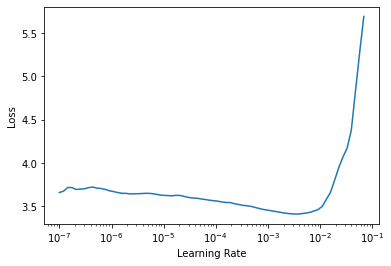

In [31]:
learn.lr_find()

In [32]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,3.680609,3.263556,26.142347,02:40


In [33]:
df_valid.head(1)

,0
0,"\n = Tropical Storm <unk> ( 2008 ) = \n \n Tropical Storm <unk> was the tenth tropical storm of the 2008 Atlantic hurricane season . <unk> developed out of a strong tropical wave which moved off the African coast on August 31 . The wave quickly became organized and was declared Tropical Depression Ten while located 170 mi ( 270 km ) to the south @-@ southeast of the Cape Verde Islands on September 2 . The depression was quickly upgraded to Tropical Storm <unk> around noon the same day . Over the next several days , <unk> moved in a general west @-@ northwest direction and reached its peak..."


In [34]:
prompt = "\n = Unicorn = \n \n A unicorn is a magical creature with a rainbow tail and a horn"

In [48]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 21])

In [49]:
preds = learn.model.generate(inp, max_length=40, num_beams=5, temperature=1.5)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [50]:
preds[0]

tensor([  198,   796, 39481,   796,   220,   198,   220,   198,   317, 44986,
          318,   257, 10883,  7185,   351,   257, 27223,  7894,   290,   257,
        12718,   319,   663,  1182,    13,   198,   198,    32, 44986,   318,
          257, 10883,  7185,   351,   257, 27223,  7894,   290,   257, 12718],
       device='cuda:0')

In [51]:
tokenizer.decode(preds[0].cpu().numpy())

'\n = Unicorn = \n \n A unicorn is a magical creature with a rainbow tail and a horn on its head.\n\nA unicorn is a magical creature with a rainbow tail and a horn'